<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/topology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Algebraic Topology**

https://github.com/giotto-ai/stock-market-crashes/blob/master/Stock%20Market%20Crash%20Detection.ipynb

https://towardsdatascience.com/detecting-stock-market-crashes-with-topological-data-analysis-7d5dd98abe42

## **Libraries**

**Additional Installations**

https://scikit-tda.org

https://github.com/scikit-tda/scikit-tda

https://scikit-tda.org/libraries.html

In [0]:
!pip install scikit-tda --q
!pip install giotto-learn --q
!pip install -U giotto-tda --q
# !pip install plotting --q

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 870kB 2.9MB/s 
     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 3.2MB 20.1MB/s 


**General Libraries**

In [0]:
# General Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Topology Libraries**

In [0]:
import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.pipeline import Pipeline

# from plotting import plot_diagram, plot_point_cloud, plot_crash_detections, plot_crash_comparisons
from gtda.plotting import plot_diagram, plot_point_cloud

## **Data Import**

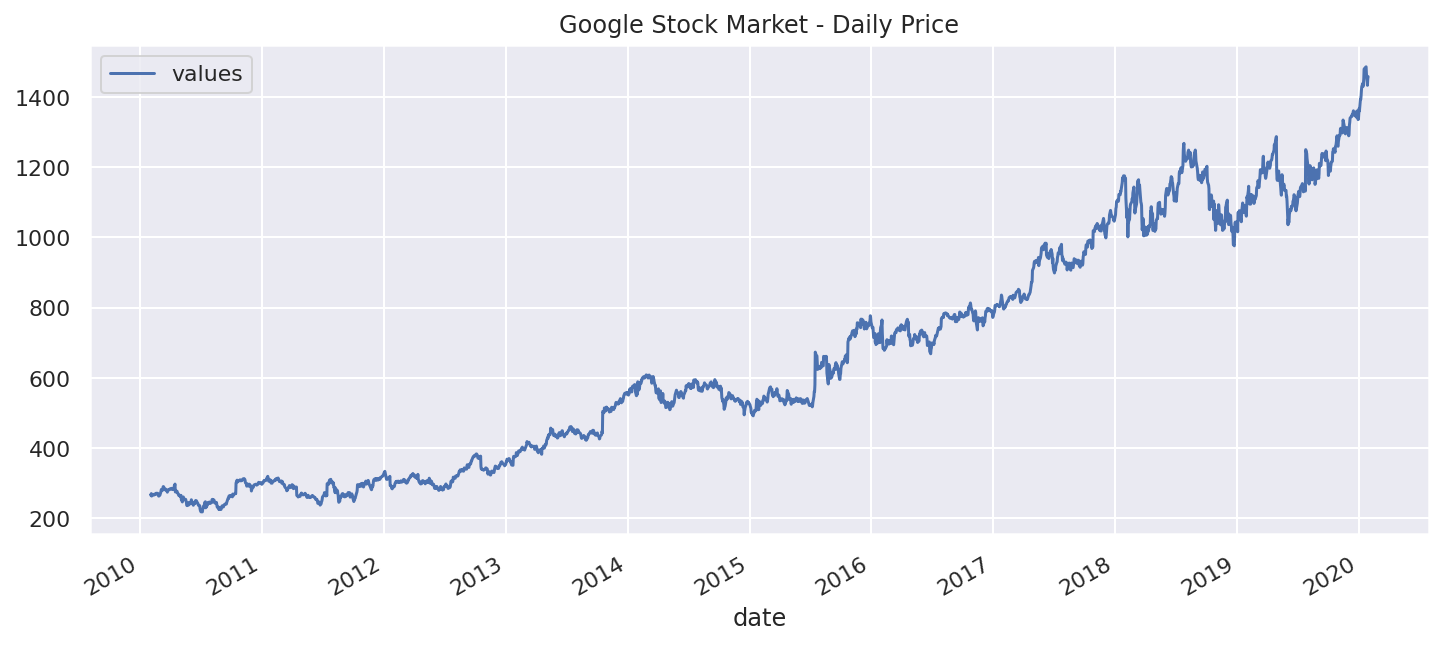

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "values"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)

sns.set(rc={'figure.figsize':(12, 5)})

series.plot(title='Google Stock Market - Daily Price')

# **Introduction into TDA for Time Series**

**A typical workflow is:**

1. **Create a point cloud** out of a finite dataset using a specific metric (Transform time series into point cloud by Taken's embedding).

2. **Construct a simplicial complex** via triangulation or a family of simplicial complex via filtration (construct a filtered cell complex from the point set S approximating the topology of X), typically via Čech Complex & Vietoris-Rips complex to get connected components

3. **Identify the most stabile invariant(s)** by increasing the ε ball monitoring the birth and death of connected components (during filtration) in a persistent diagram (topologically characterize this complex using topological invariants. The computed invariants then provide information about the underlying space X from which the data is assumed to have been sampled) - Create persistent barcode. Transform barcode into persistent diagram. Transform diagram into persistent landscape. Compute betti numbers as most stabile invariants

# **Point Clouds (Takens Embedding)**

In [0]:
embedding_dimension = 3
embedding_time_delay = 2

In [0]:
embedder = ts.TakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

In [0]:
price_values = series.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

In [0]:
window_width = 30
window_stride = 4

In [0]:
sliding_window = ts.SlidingWindow(width=window_width, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

In [0]:
window_num = 100
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

# **Persistence diagrams**

In [0]:
# define the number of homology dimensions to track
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=1)

# Fit into a persistent diagram
diagrams = VR.fit_transform(price_embedded_windows)

In [0]:
plot_diagram(diagrams[window_num])

## **Homological derivatives**

In [0]:
from gtda.utils.validation import *

# from gtda.utils.validation import check_diagram,
# from gtda.utils.validation import validate_params
# from gtda.utils.validation import validate_metric_params

In [0]:
from gtda.utils.validation import validate_params

In [0]:
from gtda.utils.validation import check_diagrams

In [0]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):
        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])
        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = (
                np.concatenate(Xt).reshape(len(self.homology_dimensions_), len(X) - 1).T
            )
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

# **Landscape distances**

In [0]:
metric_params = {"p": 2, "n_layers": 20, "n_bins": 1000} # "n_values": 1000

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=1,
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)

Text(0.5, 1.0, 'Landscape Distances for Google')

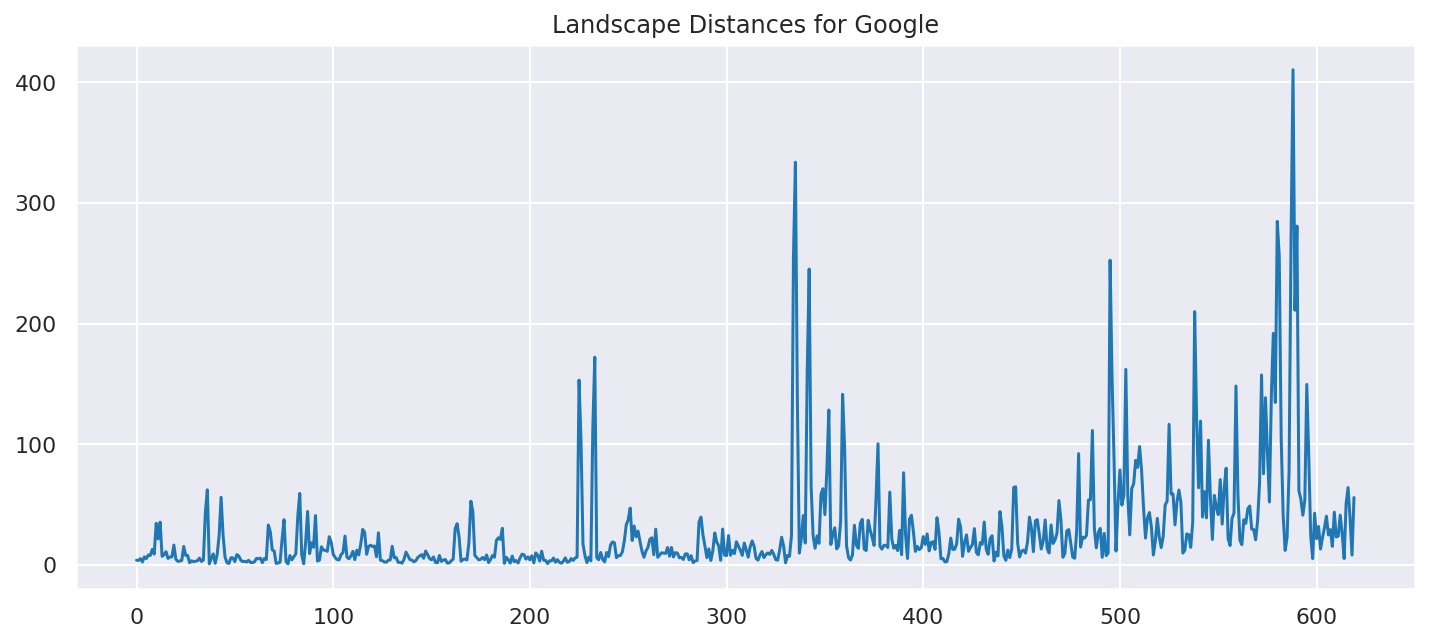

In [0]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances for Google")

## **Distances among diagrams using Betti curves**

In [0]:
bettiHomDer = HomologicalDerivative(metric='betti',
                                    metric_params=metric_params,
                                    order=2, n_jobs=1)

In [0]:
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

KeyError: ignored

NameError: ignored

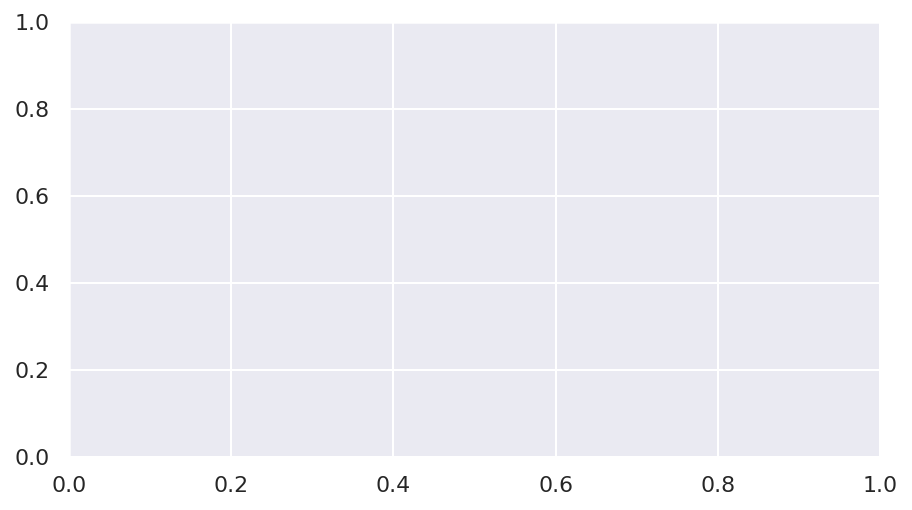

In [0]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Norm of L^p difference')

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs)
plt.title('Price')
plt.show()

NameError: ignored

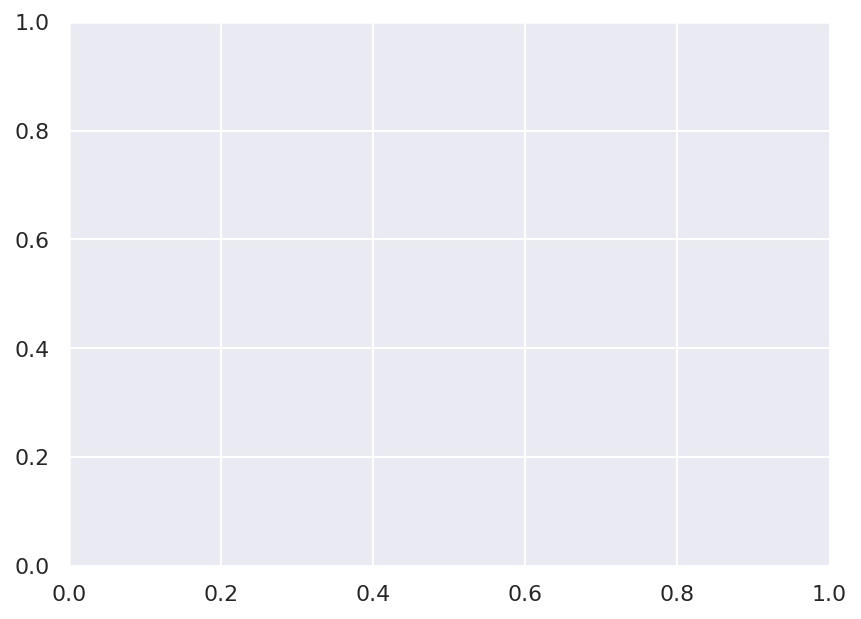

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, "#1f77b4")
plt.title("Landscape Distances of the S&P 500 Index")

plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances of the S&P 500 Index')
plt.savefig('./images/metric_landscape_betti.png')
plt.show()